## 获取数据

In [ ]:
import jqdatasdk as jq
import os
jq.auth()

In [3]:
# 获得行业代码--二级行业
# 申万行业分类--134个二级行业
industries_df = jq.get_industries('sw_l2', date='2022-5-1')
industries_total = industries_df.index.tolist()
industries_df.head()

,name,start_date
801993,旅游及景区II,2021-12-11
801744,船舶制造II,2014-02-21
801745,军工电子II,2021-12-11
801742,航空装备II,2014-02-21
801743,地面兵装II,2014-02-21


In [4]:
# 筛选出合适的行业
industries_list = []
for industry in industries_total:
    securities = jq.get_industry_stocks(industry)
    if len(securities)>80:
        industries_list.append(industry)
print(f'共选择了{len(industries_list)}个申万二级行业')

共选择了15个申万二级行业


### 所选行业
电力、电子制造、汽车零部件、环境治理、房地产开发、光学光电子、半导体、化学制品、软件开发、IT服务、专用设备、通用机械、医疗器械、化学制药、电网设备

In [6]:
# 获取行业内股票数据（15minbar）
path = ''
for industry in contd_list:
    securities = jq.get_industry_stocks(industry)
    file_name = industry+'_15min.csv'
    output_file = os.path.join(path, file_name)
    df = jq.get_bars(securities, 5000, unit='15m', fields=['date','open','close'], include_now=False, end_dt='2022-5-1')
    df.to_csv(output_file)

## 数据处理

In [7]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from sklearn.linear_model import LinearRegression

In [8]:
# 读取文件
file_name = '801034_15min.csv'
read_file = os.path.join(path, file_name)
df = pd.read_csv(read_file)
df.columns = ['Stkcd', 'order', 'date', 'open', 'close']
df.head()

,Stkcd,order,date,open,close
0,688089.XSHG,0,2021-01-13 13:15:00,34.98,34.66
1,688089.XSHG,1,2021-01-13 13:30:00,34.63,34.50
2,688089.XSHG,2,2021-01-13 13:45:00,34.53,34.56
3,688089.XSHG,3,2021-01-13 14:00:00,34.56,34.72
4,688089.XSHG,4,2021-01-13 14:15:00,34.67,34.84


In [9]:
# 更改DataFrame表头
df['Stkcd'] = df['Stkcd'].str.split('.').apply(lambda x: x[0])
df['return'] = (df['open']-df['close'])/df['open']
df.set_index('order', inplace=True)
df.head(3)

,Stkcd,date,open,close,return
order,,,,,
0,688089,2021-01-13 13:15:00,34.98,34.66,0.009148
1,688089,2021-01-13 13:30:00,34.63,34.50,0.003754
2,688089,2021-01-13 13:45:00,34.53,34.56,-0.000869


### 市值数据处理

In [10]:
# 读取流通市值数据
df1 = pd.read_csv('STK_MKT_DALYR.csv')
df2 = pd.read_csv('STK_MKT_DALYR1.csv')
size_df = pd.merge(df1, df2, how='outer')
size_df.columns = ['trading_date','Stkcd','short_name','size']
size_df.tail(3)

,trading_date,Stkcd,short_name,size
1807647,2022-04-27,900957,凌云B股,601087593.6
1807648,2022-04-28,900957,凌云B股,592909603.2
1807649,2022-04-29,900957,凌云B股,630746222.4


In [11]:
# 对DataFrame进行处理，并完成合并
df1 = df.copy()
df1['trading_date'] = df1['date'].str.split(' ').apply(lambda x: x[0])
df1['Stkcd'] = df1['Stkcd'].astype(np.int64)
df1 = pd.merge(df1, size_df, on=['trading_date', 'Stkcd'], how='left')
df['Size'] = df1['size']
df = df[['Stkcd', 'date', 'return', 'Size']]
df.head(3)

,Stkcd,date,return,Size
order,,,,
0,688089,2021-01-13 13:15:00,0.009148,2.278536e+09
1,688089,2021-01-13 13:30:00,0.003754,2.278536e+09
2,688089,2021-01-13 13:45:00,-0.000869,2.278536e+09


In [12]:
df.isna().sum()

Stkcd     0
date      0
return    0
Size      0
dtype: int64

## 结论验证
验证过程中的中间步骤，使用**df1**而不是**df**，以防止原DataFrame被影响      
df1包含字段：stkcd, date, open, close, return, trading_date, short_name, size	

结论1：小市值公司有更高的平均收益      
思路：对每一时间段内不同组的收益率进行计算比较

In [13]:
# 更换合适的索引（计算月平均）
df1['year'] = df1['trading_date'].str.split('-').apply(lambda x:x[0])
df1['month'] = df1['trading_date'].str.split('-').apply(lambda x: x[1])
df1['time'] = df1['year']+df1['month']
df1['time'] = df1['time'].astype(int)
df1.head(1)

,Stkcd,date,open,close,return,trading_date,short_name,size,year,month,time
0,688089,2021-01-13 13:15:00,34.98,34.66,0.009148,2021-01-13,嘉必优,2.278536e+09,2021,01,202101


In [14]:
# 求差值验证结论1
diff = []
time = 0
for i in range(1,17):
    if i in range(1,13):
        time = 202100+i
    elif i in range(13,17):
        time = 202200+i-12

    df2 = df1[df1['time']==time]
    avg_size = df2[['Stkcd', 'size', 'time']].groupby(['Stkcd','time']).apply(lambda x:x['size'].mean()).reset_index()
    avg_size_df = DataFrame(avg_size)
    avg_size_df.columns = ['Stkcd', 'time', 'avg_size']

    avg_return = df2[['Stkcd', 'return', 'time']].groupby(['Stkcd','time']).apply(lambda x:x['return'].mean()).reset_index()
    avg_return_df = DataFrame(avg_return)
    avg_return_df.columns = ['Stkcd', 'time', 'avg_return']

    avg_df = pd.merge(avg_size_df, avg_return_df, on=['Stkcd', 'time'], how='left')
    large_group_return = avg_df['avg_return'][avg_df.avg_size.rank(pct=True)>=0.7].mean()
    small_group_return = avg_df['avg_return'][avg_df.avg_size.rank(pct=True)<=0.3].mean()
    diff.append((time,large_group_return-small_group_return))
diff = DataFrame(diff)
diff.columns = ['time', 'difference']

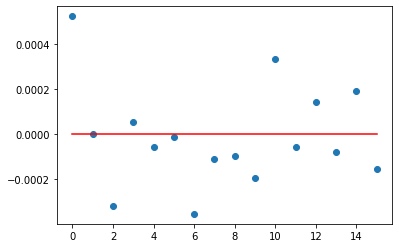

In [15]:
# 结论1可视化
x = np.arange(16)
y = 0 * x
plt.plot(x,y,color='red')
plt.scatter(diff.index,diff['difference'])

### 结论2: 自回归系数会随着公司规模扩大而降低

In [16]:
# 自相关系数函数
def autocorrelation(x,lags):
	'''
	Calculate lags order autocorrelations
	Return lags value
	Series mean and variance constant
	'''
	n = len(x)
	x = np.array(x)
	variance = x.var()
	x = x-x.mean()
	result = np.correlate(x, x, mode = 'full')[-n+1:-n+lags+1]/\
		(variance*(np.arange(n-1,n-1-lags,-1)))
	return result

In [17]:
# 计算自回归系数 (月度自相关)
for i in range(1,17):
    if i in range(1,13):
        time = 202100+i
    elif i in range(13,17):
        time = 202200+i-12

    df2 = df1[df1['time']==time]
    ac_df = DataFrame(df2[['Stkcd','time','return']].groupby(['Stkcd','time']).apply(lambda x:(autocorrelation(x['return'],1))).reset_index())
    ac_df.columns = ['Stkcd', 'time', 'autocorrelation']
    ac_df = pd.merge(ac_df, avg_size, on=['Stkcd','time'], how='left')
    ac_df.sort_values(by='avg_size', ascending=True, inplace=True)
ac_df.head()

,Stkcd,time,autocorrelation,avg_size
68,301037,202204,[-0.0908751740616616],4.653784e+08
69,301059,202204,[-0.044212688321121234],4.857542e+08
71,301076,202204,[0.06034456566675582],5.582737e+08
123,688129,202204,[0.007681710886113923],5.881059e+08
67,301036,202204,[0.039764466474146526],5.927105e+08


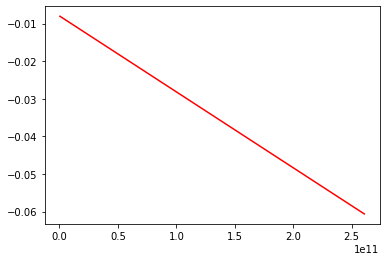

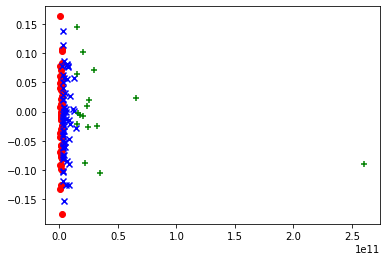

In [18]:
# 结论2可视化
from sklearn.linear_model import LinearRegression

d1 = ac_df['avg_size'].__array__().reshape(-1,1)
d2 = ac_df['autocorrelation'].__array__().reshape(-1,1)

reg=LinearRegression()
reg.fit(d1,d2)
plt.plot(d1,reg.predict(d1),color="red")
plt.show()
plt.scatter(d1[:60], d2[:60], color='red', marker='o')
plt.scatter(d1[60:120], d2[60:120], color='blue', marker='x')
plt.scatter(d1[120:180], d2[120:180], color='green', marker='+')
plt.show()
# sns.regplot(x=d1, y=d2, marker='+', label='Distribution Dots', truncate=False, line_kws={'label': 'Regression Line'})

#### 注意
上述两个结论仍然是用日数据进行验证，可以转为日内15分钟数据进行进一步验证

### 结论3：向量自回归（日内数据 15minbar）

本节中，核心内容是将日内数据做成索引，便于后续遍历等操作      
类似地，我们用df2作为中间步骤的DataFrame      
**min_df为该部分的主要使用DataFrame**

In [20]:
df_group = df.groupby('date').count()
df_group.head(3)

,Stkcd,return,Size
date,,,
2020-12-29 13:15:00,5,5,5
2020-12-29 13:30:00,5,5,5
2020-12-29 13:45:00,5,5,5


In [21]:
# 获得所有时间
minbar_list = df['date'].drop_duplicates().drop_duplicates().tolist()
minbar_list.sort()

In [22]:
df.head(1)

,Stkcd,date,return,Size
order,,,,
0,688089,2021-01-13 13:15:00,0.009148,2.278536e+09


In [74]:
# 将表格进行分组并合并
cols = ['large_group', 'large_return', 'date', 'small_group', 'small_return']
df1 = DataFrame(columns=cols)
df1['large_return'] = df1['large_return'].astype(np.float64)
df1['small_return'] = df1['small_return'].astype(np.float64)

for minbar in minbar_list:
    df2 = df[df['date']==minbar]
    large_group = DataFrame(df2['Stkcd'][df2.Size.rank(pct=True)>0.7])
    merge1 = pd.merge(large_group, df2[['Stkcd', 'return', 'date']], on='Stkcd', how='left')
    merge1.columns = ['large_group', 'large_return', 'date']

    small_group = DataFrame(df2['Stkcd'][df2.Size.rank(pct=True)<0.3])
    merge2 = pd.merge(small_group, df2[['Stkcd', 'return']], on='Stkcd', how='left')
    merge2.columns = ['small_group', 'small_return']

    result = pd.concat([merge1, merge2], axis=1).dropna()
    df1 = pd.merge(df1, result, how='outer')

In [85]:
# 创建min_df
min_df = df1[['date','large_return','small_return']]
min_df.set_index('date',inplace=True)
min_df.head(3)

,large_return,small_return
date,,
2021-01-06 13:15:00,-0.000916,-0.009950
2021-01-06 13:15:00,0.010395,0.004832
2021-01-06 13:30:00,0.007809,0.004926


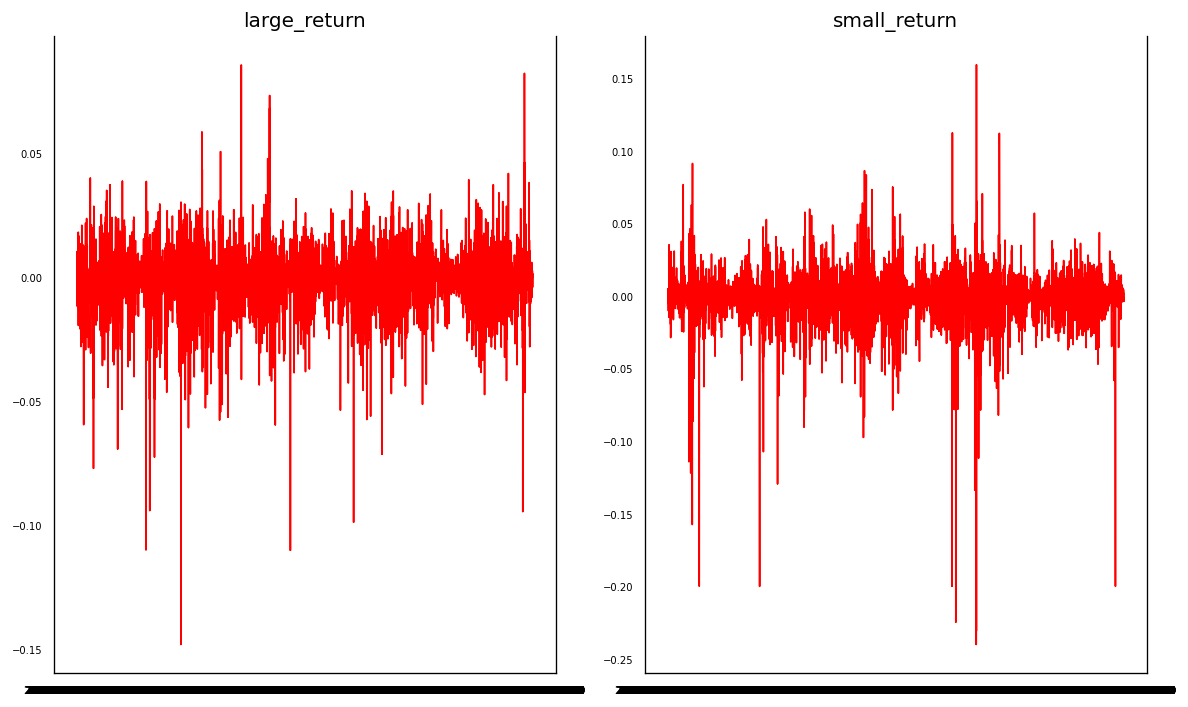

In [86]:
# 将时间序列可视化
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data=min_df[min_df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    #decorations
    ax.set_title(min_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
    plt.tight_layout()

#### 格兰杰因果关系检验
向量自回归的基础是探究系统中不同时间序列是否存在相互影响。使用格兰杰因果关系检验在建立VAR模型之前验证了这样的关系，原假设为回归方程中过去值的系数为零

In [88]:
# 格兰杰因果关系检验
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(min_df, variables = min_df.columns)  

,large_return_x,small_return_x
large_return_y,1.0,0.0
small_return_y,0.0,1.0


In [89]:
# 协整检验
from statsmodels.tsa.vector_ar.vecm import coint_johansen

#### 协整检验
原假设是没有协整方程，拒绝原假设-->一个非平稳变量的组合给出了一个平稳过程

In [90]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johansen's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(min_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
large_return ::  4963.83   > 12.3212   =>   True
small_return ::  2226.58   > 4.1296    =>   True


#### ADFuller平稳性检验
如果序列不是平稳的，我们对序列进行做差直到序列平稳

In [91]:
# 划分训练集与测试集
nobs = 20      
df_train, df_test = min_df[0:-nobs], min_df[-nobs:]

In [92]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "large_return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.3666
 No. Lags Chosen       = 23
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "small_return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -33.0532
 No. Lags Chosen       = 15
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [93]:
# 选择滞后阶数
model = VAR(df_train)
x = model.select_order(maxlags=12)
x.summary()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-18.81,-18.81,6.765e-09,-18.81
1,-18.82,-18.82,6.694e-09,-18.82
2,-18.83,-18.83*,6.644e-09,-18.83
3,-18.83*,-18.82,6.637e-09*,-18.83*
4,-18.83,-18.82,6.637e-09,-18.83
5,-18.83,-18.82,6.639e-09,-18.83
6,-18.83,-18.82,6.639e-09,-18.83
7,-18.83,-18.82,6.640e-09,-18.83
8,-18.83,-18.82,6.640e-09,-18.83
9,-18.83,-18.81,6.638e-09,-18.82


In [94]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Jun, 2022
Time:                     11:30:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.8251
Nobs:                     17537.0    HQIC:                  -18.8292
Log likelihood:           115368.    FPE:                6.63264e-09
AIC:                     -18.8313    Det(Omega_mle):     6.62735e-09
--------------------------------------------------------------------
Results for equation large_return
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.000131         0.000059           -2.237           0.025
L1.large_return         0.063536         0.007562            8.402           0.000
L1.small_return         0.023585         0.00